In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [3]:
all_chars = string.printable
n_chars   = len(all_chars)
file      = open('./trump.txt', encoding="utf-8").read()
file_len  = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 5569684
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [4]:
# Turning a string into a tensor.
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_chars.index(string[c])
        except:
            continue
    return tensor

In [5]:
def training_set(seq_len, batch_size):
    input = torch.LongTensor(batch_size, seq_len)
    target = torch.LongTensor(batch_size, seq_len)
    for i in range(batch_size):
        start_index  = random.randint(0, file_len - seq_len - 1)
        end_index    = start_index + seq_len + 1
        seq          = file[start_index:end_index]
        input[i]     = char_tensor(seq[:-1])
        target[i]    = char_tensor(seq[1:])
    input  = Variable(input)   # Wrap up the tensor to backpropagate a loss function
    target = Variable(target)  # Wrap up the tensor to backpropagate a loss function
    if torch.cuda.is_available():
        input  = input.cuda()
        target = target.cuda()
    return input, target

In [6]:
class charRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model='gru', n_layers=1):
        # Initialization.
        super(charRNN, self).__init__()
        self.model = model.lower()
        self.input_size  = input_size        # Input size: Number of unique chars.
        self.hidden_size = hidden_size       # Hidden size: 100.
        self.output_size = output_size       # Output size: Number of unique chars.
        self.n_layers = n_layers
        
        # Use Word Embeddings to encode semantic similarity in words instead of one-hot
        self.embeds = nn.Embedding(input_size, hidden_size)
        if self.model == "rnn":
            self.rnn = nn.RNN(input_size, hidden_size, n_layers)
        elif self.model == "gru":
            self.rnn = nn.GRU(input_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(input_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        # Forward function.
        batch_size = input.size(0)
        encoded = self.embeds(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def forward2(self, input, hidden):
        encoded = self.embeds(input.view(1, -1))
        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden
    
    def init_hidden(self, batch_size):
        # Initial hidden state.
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [7]:
def train_step(net, opt, input, target):
    hidden = net.init_hidden(batch_size) # Initial hidden state.
    if torch.cuda.is_available():
        hidden = (hidden[0].cuda(), hidden[1].cuda())     # LSTM hidden state is a tuple
    net.zero_grad()                      # Clear the gradient.
    loss = 0                             # Initial loss.
    
    for t in range(seq_len):            # For each one in the input sequence.
        output, hidden = net(input[:,t], hidden)
        loss += loss_func(output.view(batch_size, -1), target[:,t])
        
    loss.backward()                      # Backward. 
    opt.step()                           # Update the weights.
    
    return loss.item() / seq_len       # Return the average loss w.r.t sequence length.

In [8]:
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden = net.init_hidden(1)
    init_input = Variable(char_tensor(init_seq).unsqueeze(0))
    if torch.cuda.is_available():
        hidden = (hidden[0].cuda(), hidden[1].cuda())
        init_input = init_input.cuda()
    predicted_seq = init_seq
    
    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        _, hidden = net(init_input[:,t], hidden)
    
    # Set current input as the last character of the initial string.
    input = init_input[:,-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.data.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence
        predicted_char = all_chars[predicted_index]
        predicted_seq += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = Variable(char_tensor(predicted_char).unsqueeze(0))
        if torch.cuda.is_available():
            input = input.cuda()
    
    return predicted_seq

In [14]:
seq_len = 200
batch_size = 100
hidden_size = 100
learning_rate = 0.01
iters = 20000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the netword, optimizer and the loss function.
net = charRNN(n_chars, hidden_size, n_chars, model='lstm', n_layers=2)
opt = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    net.cuda()

# Training procedure.
for i in range(iters):
    input, target = training_set(seq_len, batch_size)
    loss = train_step(net, opt, input, target)
    loss_sum += loss
    
    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
        
        #Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/20000 loss:2.761633183288573
generated sequence: Wers smat the veralie to in you gake.
"-/itt. Trump" Thuspiy, okews of mast Agopion!
Think illed 05pu

iter:199/20000 loss:2.0040257202148437
generated sequence: Wed Supmenop Ba_Fox! @ realDonaldTrump"
" @ Rangreacono-zCarus 18 divering and @ Trump @ realDonaldTr

iter:299/20000 loss:1.8230300857543946
generated sequence: Won
" @ Ber242: @ realDonaldTrump.com/Coughtshow Plosal DonaldTrump the meate quulcom, mistronging No

iter:399/20000 loss:1.7356115524291993
generated sequence: What want it Much had runners injices not the manioldy get is were going!
@ WNONQ the recession Mr. T

iter:499/20000 loss:1.6851543594360356
generated sequence: We is that so'd low' to sugge that a strivers and that!
. @ realDonaldTrump ISI this Pany from Mean o

iter:599/20000 loss:1.6524069717407235
generated sequence: Wgls thank you nextiaa--his just be a victuring or parliend who wonderful of fuckles Connernce, now. 

iter:699/20000 loss:1.62665314

iter:5199/20000 loss:1.438961294555664
generated sequence: Wressure!http://bit.ly/1b4VcDOh/hjl6f
Hillary Get for heldesing. Very project places in the never nev

iter:5299/20000 loss:1.4346401687622075
generated sequence: What Hall. He work with innocent to Balanch Sunday-_itize Huger @ realDonaldTrump, Tokest Golf Chrism

iter:5399/20000 loss:1.4330600585937505
generated sequence: Wouk.
" @ Apprentobensorse870: @ ApprenticeNBC @ FoxNews on the in land delay? Calinistuming with SDC

iter:5499/20000 loss:1.4353798675537108
generated sequence: Waynesweing will to $$M) is a very siquaters act refusing in ANCn FOH0very people, and will end0 cut!

iter:5599/20000 loss:1.4309304397583
generated sequence: What and fight again this intervieway-sears for Iran, they were you like. This past as (a scream-are.

iter:5699/20000 loss:1.4337850784301758
generated sequence: Who MUST Ferry of you!
Happy State that Ukraine!
Had a wonderful-to be fully use, Forgate and I have 

iter:5799/20000 loss:1.432

iter:10299/20000 loss:1.4121191070556642
generated sequence: WaltinThat - bad lawder job soech, the evidence of great picker.
Noo was Mantal. We are tHAwept on Ap

iter:10399/20000 loss:1.4147849243164061
generated sequence: W ATGAIN!
" @ DoralRI40m Massive julong as go at the Carry Hillary Bushting Journing led with USPANTI

iter:10499/20000 loss:1.4173373535156246
generated sequence: WAY seasus in the Wall!
" @ tiamiadiouhing @ GACKevin: "Please you plus with the brilliant that becau

iter:10599/20000 loss:1.4173363845825195
generated sequence: Wread on Cruz,0 promises our great could be the Alls, it's fellegu) Muslitte in U.S."housey against t

iter:10699/20000 loss:1.4141780059814448
generated sequence: We run for pres in 14th.
U @ xillenFier! 1 PM OF BURIFFO witive that0s full a got more gun playing in

iter:10799/20000 loss:1.4145854675292973
generated sequence: Wates and get reasons on? I will a very deary BinLitamLeush Day RabyAua" pic.twitter.com/4T7gGHnX78
0

iter:10899/20000

iter:15399/20000 loss:1.4040238174438477
generated sequence: Why's voting with that's get down is in care of your develable to a stuge of friends!
SarahAKN!pic.tw

iter:15499/20000 loss:1.404264292907715
generated sequence: W SO1 UST.
Great things to other two yean http://bit.ly/YIP73z
Democrat Wars at 7:30 Skill Tower on I

iter:15599/20000 loss:1.407200610351562
generated sequence: Watchen of Find Highes @ realDonaldTrump! $500MB's killing 23. # Saunton hard jund @ realDonaldTrump 

iter:15699/20000 loss:1.417999285888672
generated sequence: W of him spaning, FBI. @ TheRroyPolitics is songing, Harry America--- hope @BretantNew for pres!
" @ 

iter:15799/20000 loss:1.412457141113281
generated sequence: WIN/Rhpion on its honest with Ted Cruzie!"
" @ GoxNewMership A Are When" Thank you.
Yes!"
" @ BosTer 

iter:15899/20000 loss:1.4072055374145507
generated sequence: Watch!
0"https://twitter.ce/trump-inconder-event-eth-in-the-pesticlements-torn-on-waites-fied-dor-thi

iter:15999/20000 los

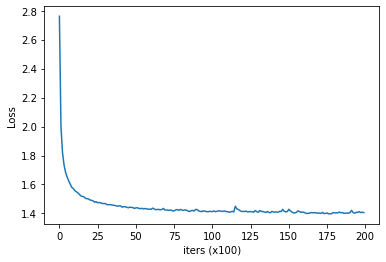

In [15]:
plt.xlabel('iters (x100)')
plt.ylabel('Loss')
plt.plot(all_losses)
plt.show()

In [10]:
lstm_loss = all_losses
%store lstm_loss

Stored 'lstm_loss' (list)


#### Generate a Sequence

In [48]:
print(eval_step(net, init_seq='I love Chi', predicted_len=1000))

I love China. Totally seasons, of America about Crime, and he would have totally always robs them ready."
" @ DonLibraGotebAmer: Jere Kill at 6:1pic.twitter.com/pmFSOx0jvQ
Just let up fast being being there was terrible foremary!
Ovajo Wrong & Kin Ceeni at 12,000 simply on a truly we should thou campaign J.GOP # GOPDebate
She is worse as should0s helping I was bad, all done to come. Mediew scrupiour" show in funny, a masterpisone that Afric air and leads on mylly family0Most Tittestly Supremee who is treative? Chicago (cont) http://tl.gd/ltp6kk
The really Rollins is the collusion much negetings of me.
" @ MareNehnerritzFow: @ realDonaldTrump was a big great least men after the hotel of my secrete seeks to speak trump was a comments of community---and they would go?" The Deal' and others on beyonder than his campaign informed a disaft, Cue) is winning @ CTMO. Tickets is which we have the Celebrity Apprentice Mr. Trump trial handle in hurricane. Now the hotten to the biggest commercial e

In [17]:
import os
def save(filename):
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    torch.save(net, save_filename)
    print('Saved as %s' % save_filename)

In [37]:
save("LaTeX_LSTM")

Saved as LaTeX_LSTM.pt


In [41]:
save("Shakespeare_LSTM")

Saved as Shakespeare_LSTM.pt


In [19]:
save("Trump_LSTM")

Saved as Trump_LSTM.pt


In [22]:
Llstm = torch.load("LaTeX_LSTM.pt")
print(eval_step(Llstm, init_seq='\\begin{document}', predicted_len=600))

\begin{document}
The map $C \to S^{sh} = \mathfrak m
= \dim(R) \to \mathcal{O}_{X, x} \circ \widetildex_{X(R)} &
R_2|_X(V, 0, a_1, \ldots, m_k)
\longrightarrablbdathbf-rh-theor tor-cohomork}_\mathcal{Y}
$$$
\item Formal 1 and
\ref{algebra-lemma-formally-fleomorible-base}
we have a choup category $\beta \otimes_{\mathcal{Y}}^\QP) \to K} \circ \Im(\mathcal{F})
=
\lim_\varphi^*\mathcal{O}_\mathcal{G}_i \otimes_R^\mathbf{L}
\ar[d]_{r[x} \ar[u]^{jg} i_{m, {-1}}, \ldots, k_i - \pi_{kj}^1^{dg}(\mathcal{I}^!\mathcal{C})(\Curvesstack)
a contraindy $A^d = u(U_U)$ and rerification.
To see that $\mathcal{F}'_i$ by $Z_i$ 
